In [1]:
import sys
import os

import joblib
import pandas as pd

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, print_info_features, print_info_targets, get_dimensions, metrics_r, get_device, plot_history, load_best_params, print_best_params_nn, fmt_time, save_best_params, \
    save_tuning_history, plot_tuning_heatmap, print_tuning_top_results, load_tuning_history, plot_param_loss_corr, \
    read_target_tensors

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train, tune

## Settings

In [5]:
# Set Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
# Data Path
path_features = os.path.abspath(os.path.join(os.getcwd(), "../../../data/features2"))
path_targets = os.path.abspath(os.path.join(os.getcwd(), "../../../data/targets/regression"))

# Model Path
path_models = os.path.abspath(os.path.join(os.getcwd(), "models"))
os.makedirs(path_models, exist_ok=True)

In [7]:
targets = ["StartYear", "YearRange"]

## Data

### Read Features and Targets

In [8]:
X = read_features(path_features, f_type="tensors")
print_info_features(X)

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_val_tfidf
Loaded X_val_bert
Loaded X_val_cannyhog
Loaded X_val_resnet
Loaded X_val_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<

In [9]:
y = read_target_tensors(path_targets)
print_info_targets(y)

Loaded y_train
Loaded y_val
Loaded y_test
{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1528, 2])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
}


### Load Target Scaler

In [10]:
path_scaler = os.path.join(path_targets, "y_scaler.pkl")
y_scaler = joblib.load(path_scaler)

### Dimensions

In [11]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


### Torch Datasets and Dataloaders

In [12]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## Define Parameter Grid

In [13]:
criterion = nn.MSELoss()
metrics = metrics_r
log_metrics = ["mae"]

param_grid = {
    # Architecture Params
    # "hidden_size": [128, 256, 512, 1024],
    "hidden_size": [64, 128, 256, 512],
    "activation": ["relu", "gelu"],
    # "dropout": [0, 0.1, 0.3, 0.5],
    "dropout": [0.05, 0.1, 0.2],
    # "blocks": [1, 2, 3, 5, 10],
    "blocks": [1, 2, 3],
    "hidden_size_pattern": ["decreasing", "constant"],

    # Training Params
    # "lr": [1e-2, 1e-3, 1e-4, 1e-5],
    "lr": [1e-2, 5e-3, 1e-3, 5e-4],
    # "weight_decay": [1e-5, 1e-6, 1e-7],
}

## Load or Initialize Best Params & Tuning History

In [14]:
# Load or initialize best params dictionary and tuning history table
path_params = os.path.join(path_models, "best_params.json")
path_history = os.path.join(path_models, "tuning_history.csv")

best_params = load_best_params(path_params)
print(f"Best Params Available for {len(best_params.keys())} Models")

tuning_histories = load_tuning_history(path_history)

Best Params Available for 11 Models


## Run Model Tuning



In [15]:
flag_new_model = False

def tune_helper(fts):
    global flag_new_model, best_params, tuning_histories
    ft = " + ".join(fts)

    if ft not in best_params.keys():
        flag_new_model = True
        print(f"\n🔄 Tuning MLP with '{ft.upper()}' Features")
        tuning_result, tuning_history = tune(
            param_grid,
            [X_dim[_ft] for _ft in fts],
            y_dim,
            loaders["train"][ft],
            loaders["val"][ft],
            criterion,
            metrics,
            device,
            y_scaler,
            log_metrics=log_metrics,
            log_per_M=100,
            chronology_target="years"
        )

        best_params[ft] = tuning_result
        tuning_histories[ft] = tuning_history
    else:
        print(f"\n✅ MLP with '{ft.upper()}' Features Already Tuned.", end=" ")
        print_best_params_nn(best_params[ft], param_grid, y_dim, log_metrics)

for ft in feature_types:
    tune_helper([ft])

for ft_txt, ft_img in feature_type_combos:
    tune_helper([ft_txt, ft_img])


✅ MLP with 'TFIDF' Features Already Tuned. Execution Time: 5m 11s
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr |  val_loss |     mae_0 |     mae_1 |
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+-----------+-----------+
|      BEST |         256 |       relu |     0.1 |      3 |          decreasing |   0.01 |    0.6844 |   33.5377 |   10.7080 |
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+-----------+-----------+

✅ MLP with 'BERT' Features Already Tuned. Execution Time: 8m 8s
+-----------+-------------+------------+---------+--------+---------------------+--------+-----------+-----------+-----------+
| combo_idx | hidden_size | activation | dropout | blocks | hidden_size_pattern |     lr |  val_loss |    

## Save Best Params & Tuning History

In [16]:
save_best_params("best_params.json", best_params, flag_new_model)
save_tuning_history("tuning_history.csv", tuning_histories, flag_new_model)

✅ No new tuning needed — using existing parameters.


## Evaluate Tuning Results

(0.6662147641181946, 1.0821733474731443)


📈 Tuning results for TFIDF features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
240,relu,3,0.1,256,decreasing,0.010,0.421066,0.684399,33.537663,10.708013,44.954533,13.202106,0.542196,0.226425,25.358582,9.609482
237,relu,3,0.1,128,constant,0.005,0.285425,0.685321,32.469707,10.842296,43.334324,13.429224,0.574601,0.199580,25.515350,9.248129
153,relu,2,0.1,512,decreasing,0.005,0.045035,0.692007,32.302010,10.567003,44.539143,13.363977,0.550617,0.207339,23.079529,9.199200
234,relu,3,0.1,128,decreasing,0.001,0.266397,0.692605,34.019848,10.536519,46.318768,13.137156,0.513989,0.234018,24.665375,9.573463
61,relu,1,0.1,512,constant,0.005,0.144878,0.693191,33.074722,10.645557,44.755890,13.352577,0.546233,0.208691,25.974182,8.949659



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
152,relu,2,0.1,512,decreasing,0.010,0.052155,0.714320,31.580896,10.554211,45.206734,13.583584,0.537045,0.181074,22.536041,8.758590
236,relu,3,0.1,128,constant,0.010,0.167161,0.727854,31.943359,10.930555,44.070679,13.911717,0.560021,0.141031,21.069733,8.705963
189,relu,2,0.2,512,constant,0.005,0.079707,0.721181,31.961916,10.930921,44.686962,13.742482,0.547630,0.161802,22.129639,9.666359
56,relu,1,0.1,512,decreasing,0.010,0.063857,0.699554,32.104866,10.694736,43.320610,13.621337,0.574870,0.176515,23.906372,8.192621
273,relu,3,0.2,256,decreasing,0.005,0.107546,0.706102,32.259205,10.478670,44.535717,13.558081,0.550687,0.184146,26.463104,8.369360



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
225,relu,3,0.1,64,decreasing,0.005,0.295658,0.695776,35.432465,10.268134,48.129036,12.922737,0.475257,0.258818,26.232788,8.695665
272,relu,3,0.2,256,decreasing,0.010,0.310544,0.697482,33.793522,10.339575,45.908710,13.257964,0.522556,0.219865,25.971252,8.240282
132,relu,2,0.1,64,constant,0.010,0.311657,0.698446,35.606625,10.372335,47.807880,13.006781,0.482236,0.249146,29.055878,8.887421
36,relu,1,0.1,64,constant,0.010,0.281065,0.724203,36.275181,10.422267,47.855957,13.364972,0.481195,0.207221,30.005493,8.662506
80,relu,1,0.2,256,decreasing,0.010,0.149246,0.698698,34.764214,10.450583,46.623051,13.177944,0.507582,0.229254,27.042664,8.891933


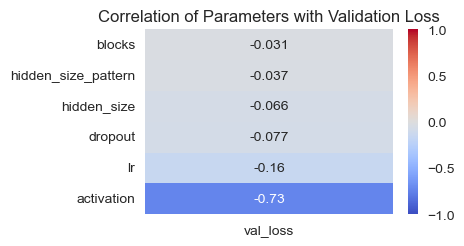

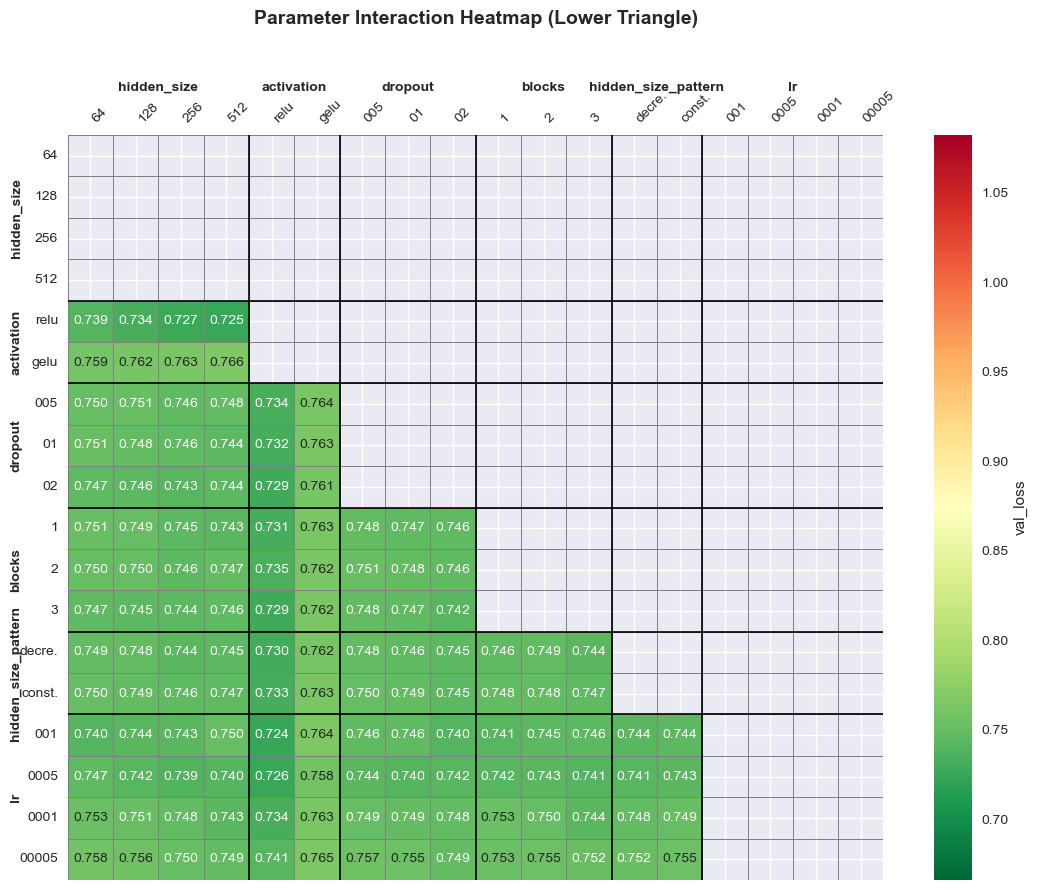



📈 Tuning results for BERT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
821,relu,3,0.10,256,constant,0.005,0.605044,0.828089,40.144424,12.286446,52.530235,14.089853,0.374898,0.118892,31.056274,12.100632
1137,gelu,3,0.20,256,decreasing,0.005,0.657922,0.828719,39.973907,12.395740,51.703220,14.216425,0.394425,0.102991,33.051758,12.119287
601,relu,1,0.05,512,decreasing,0.005,0.645676,0.834135,41.957516,12.363308,52.936481,14.107206,0.365192,0.116721,36.110565,12.134518
757,relu,2,0.20,256,constant,0.005,0.675086,0.835363,41.088314,12.326419,53.441319,14.049953,0.353026,0.123875,33.965973,12.161652
684,relu,2,0.05,128,constant,0.010,0.677225,0.837468,42.706188,12.234308,53.205406,14.114592,0.358725,0.115795,35.475311,11.844135



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
692,relu,2,0.05,256,constant,0.010,0.677018,0.843706,39.675083,12.649324,51.260342,14.469037,0.404755,0.070830,32.057922,12.166760
949,gelu,1,0.20,256,constant,0.005,0.629617,0.840274,39.726631,12.429476,51.433079,14.405694,0.400737,0.078947,31.952179,11.703495
1137,gelu,3,0.20,256,decreasing,0.005,0.657922,0.828719,39.973907,12.395740,51.703220,14.216425,0.394425,0.102991,33.051758,12.119287
821,relu,3,0.10,256,constant,0.005,0.605044,0.828089,40.144424,12.286446,52.530235,14.089853,0.374898,0.118892,31.056274,12.100632
838,relu,3,0.20,64,constant,0.001,0.613432,0.837552,40.190128,12.467697,51.957390,14.296505,0.388457,0.092857,31.867493,11.937293



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
948,gelu,1,0.20,256,constant,0.010,0.589736,0.852527,42.619816,12.067597,53.908592,14.209498,0.341663,0.103865,34.109619,10.931970
824,relu,3,0.10,512,decreasing,0.010,0.655571,0.851077,42.821842,12.088411,54.252338,14.135350,0.333240,0.113193,36.644257,11.564180
728,relu,2,0.10,512,decreasing,0.010,0.581830,0.841106,40.840645,12.111377,54.520447,13.966563,0.326634,0.134245,30.291382,11.749158
789,relu,3,0.05,256,constant,0.005,0.627224,0.890707,43.924606,12.120070,57.857117,14.101727,0.241691,0.117407,35.760956,11.488865
929,gelu,1,0.20,64,decreasing,0.005,0.575061,0.848355,41.030247,12.136445,53.319798,14.239451,0.355965,0.100083,32.288635,11.552385


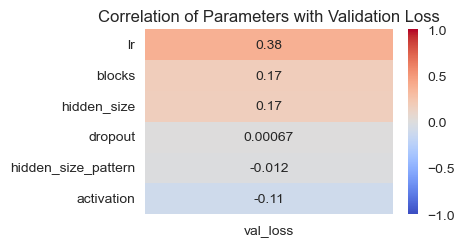

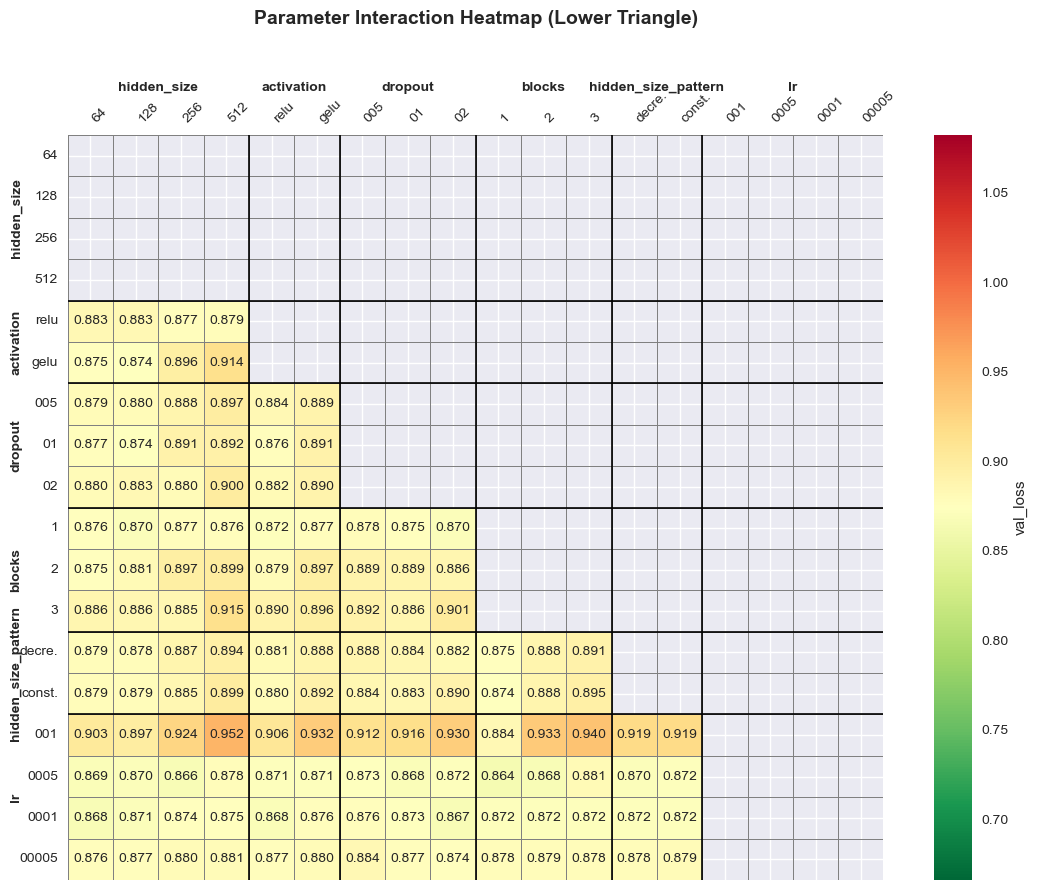



📈 Tuning results for CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1686,gelu,3,0.10,256,constant,0.0010,0.814262,0.970660,49.490341,12.683399,60.747173,14.653011,0.164042,0.047051,43.751007,12.658113
1590,gelu,2,0.10,256,constant,0.0010,0.795629,0.972956,50.209312,12.470256,61.079250,14.628198,0.154877,0.050275,44.018768,11.681675
1646,gelu,3,0.05,128,constant,0.0010,0.781667,0.975715,50.109093,12.494549,61.282940,14.629231,0.149231,0.050141,44.060699,10.899469
1695,gelu,3,0.10,512,constant,0.0005,0.825315,0.978910,49.896843,12.610686,61.088158,14.701994,0.154631,0.040669,44.418060,11.737464
1651,gelu,3,0.05,256,decreasing,0.0005,0.798393,0.981175,50.006401,12.632058,61.052704,14.736347,0.155612,0.036180,44.175476,12.519375



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1686,gelu,3,0.10,256,constant,0.0010,0.814262,0.970660,49.490341,12.683399,60.747173,14.653011,0.164042,0.047051,43.751007,12.658113
1658,gelu,3,0.05,512,decreasing,0.0010,0.849700,0.997135,49.562737,12.893363,60.999096,14.942868,0.157094,0.008976,44.024597,13.686085
1663,gelu,3,0.05,512,constant,0.0005,0.805349,0.986954,49.655006,12.632385,61.147221,14.791683,0.152995,0.028928,44.449158,11.622600
1695,gelu,3,0.10,512,constant,0.0005,0.825315,0.978910,49.896843,12.610686,61.088158,14.701994,0.154631,0.040669,44.418060,11.737464
1651,gelu,3,0.05,256,decreasing,0.0005,0.798393,0.981175,50.006401,12.632058,61.052704,14.736347,0.155612,0.036180,44.175476,12.519375



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1590,gelu,2,0.10,256,constant,0.0010,0.795629,0.972956,50.209312,12.470256,61.079250,14.628198,0.154877,0.050275,44.018768,11.681675
1646,gelu,3,0.05,128,constant,0.0010,0.781667,0.975715,50.109093,12.494549,61.282940,14.629231,0.149231,0.050141,44.060699,10.899469
1662,gelu,3,0.05,512,constant,0.0010,0.812361,0.996790,50.404247,12.543197,62.025143,14.771059,0.128499,0.031634,43.382233,11.403391
1266,relu,2,0.05,256,decreasing,0.0010,0.779368,0.988774,51.373722,12.564412,62.257210,14.632807,0.121965,0.049677,43.758514,11.249859
1551,gelu,2,0.05,128,constant,0.0005,0.811808,0.986768,50.940865,12.600545,61.896713,14.667692,0.132104,0.045140,44.904846,12.055830


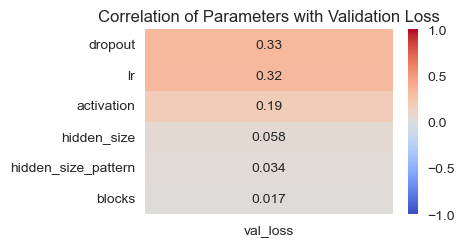

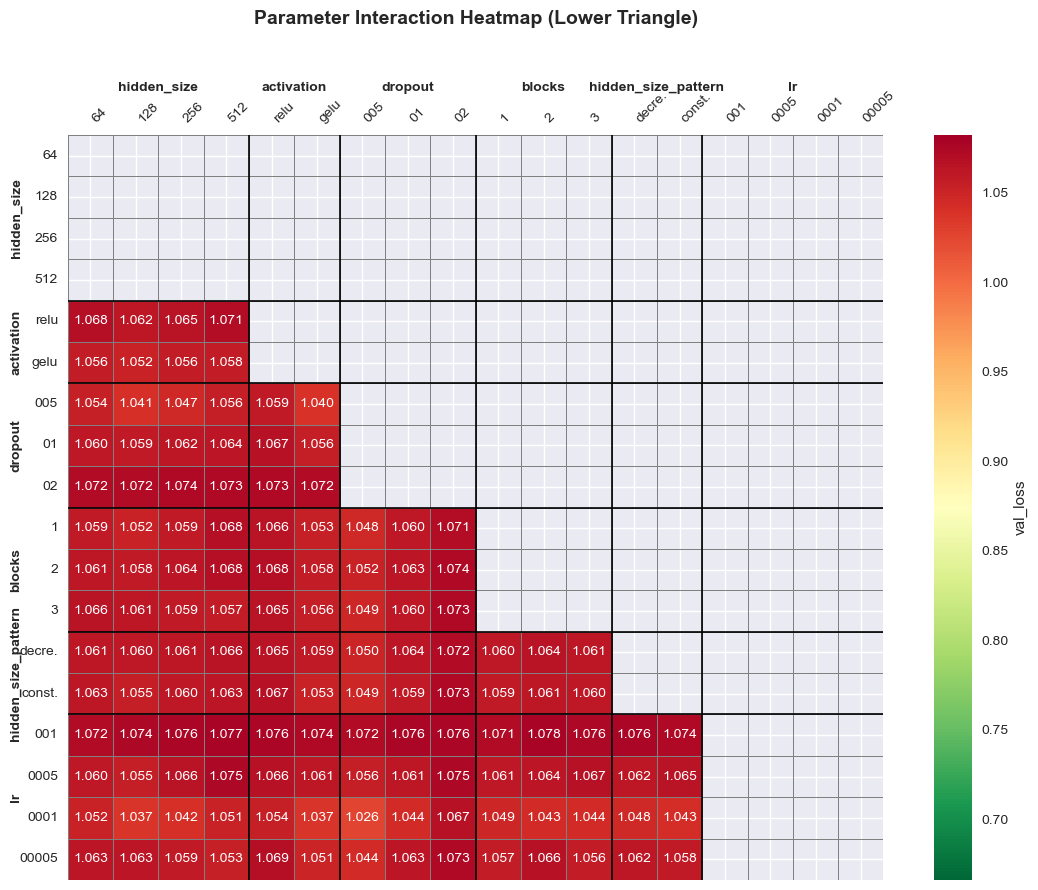



📈 Tuning results for RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2021,gelu,1,0.05,64,constant,0.0050,0.815547,0.967410,49.803265,12.494568,61.104595,14.552910,0.154176,0.060026,43.052734,12.364441
1816,relu,1,0.20,512,decreasing,0.0100,0.799506,0.968136,48.544186,12.583353,60.570629,14.649580,0.168894,0.047497,44.197205,10.673117
1780,relu,1,0.10,256,constant,0.0100,0.782594,0.968588,49.261475,12.674876,60.516026,14.664444,0.170391,0.045563,44.439758,12.701075
2009,relu,3,0.20,512,decreasing,0.0050,0.783741,0.969118,48.342010,12.565726,60.258976,14.712645,0.177424,0.039278,43.170410,11.523766
1771,relu,1,0.10,128,decreasing,0.0005,0.810439,0.970141,48.905254,12.613164,60.858971,14.627684,0.160962,0.050342,44.490082,12.339643



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2088,gelu,1,0.20,128,decreasing,0.010,0.754525,0.974620,47.119816,12.814065,59.130081,14.955793,0.207956,0.007261,40.519043,13.332189
2177,gelu,2,0.20,64,decreasing,0.005,0.715572,0.979755,48.052078,12.585682,60.511578,14.805270,0.170513,0.027144,44.317139,11.666069
1952,relu,3,0.10,64,decreasing,0.010,0.781821,0.992768,48.174824,13.026705,60.184452,15.018987,0.179457,-0.001146,43.955048,14.686516
1965,relu,3,0.10,128,constant,0.005,0.670543,0.990778,48.183380,12.775984,60.271179,14.980561,0.177091,0.003970,44.617981,11.201165
1728,relu,1,0.05,64,decreasing,0.010,0.656601,0.993895,48.192936,12.805297,60.095306,15.046970,0.181886,-0.004880,44.987640,11.915586



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
1923,relu,3,0.05,64,decreasing,0.0005,0.730972,0.980160,48.954102,12.469254,61.506931,14.648171,0.143000,0.047680,43.556793,10.793572
1760,relu,1,0.10,64,decreasing,0.0100,0.709381,0.976535,48.847031,12.475519,61.045860,14.678626,0.155801,0.043716,42.989746,10.779890
1861,relu,2,0.10,64,constant,0.0050,0.791542,0.977869,49.379368,12.477499,61.240326,14.662547,0.150414,0.045810,44.956543,10.780718
2048,gelu,1,0.10,64,decreasing,0.0100,0.873305,0.991604,50.367161,12.479962,62.525249,14.625129,0.114388,0.050674,41.597870,12.253805
1759,relu,1,0.05,512,constant,0.0005,0.755201,0.977628,49.220375,12.481442,61.260620,14.656925,0.149851,0.046541,43.817017,11.184647


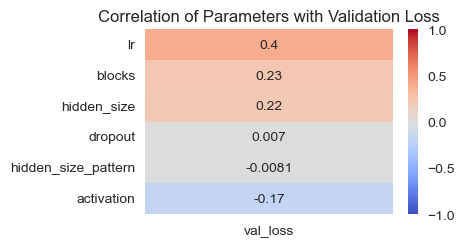

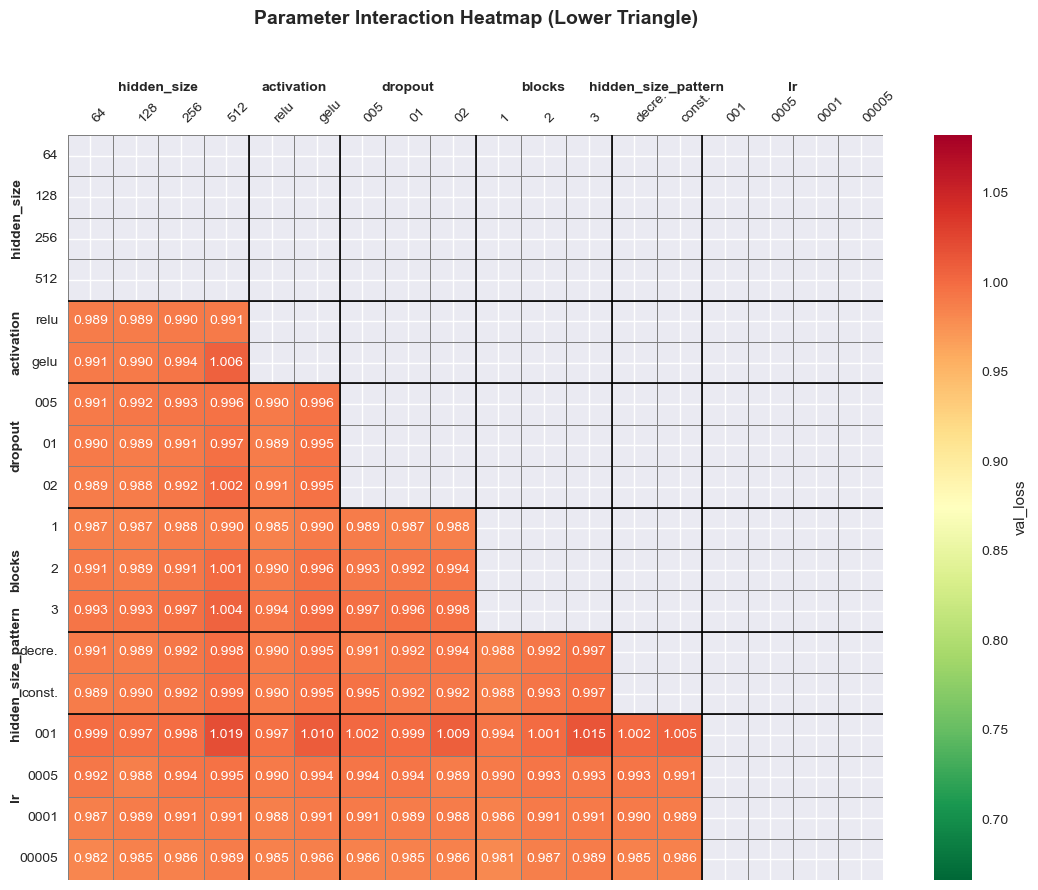



📈 Tuning results for VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2589,relu,3,0.2,512,constant,0.005,0.676419,0.939985,45.817543,12.451254,58.305408,14.649869,0.229895,0.047459,40.043640,10.507611
2457,relu,2,0.1,512,decreasing,0.005,0.685197,0.941572,46.002453,12.580492,57.869923,14.738132,0.241356,0.035947,42.723938,11.195900
2476,relu,2,0.2,128,constant,0.010,0.755144,0.942652,46.899067,12.516294,58.430695,14.664228,0.226582,0.045591,37.448151,11.207019
2368,relu,1,0.2,64,decreasing,0.010,0.690004,0.945710,46.187775,12.625601,57.862286,14.791599,0.241556,0.028939,41.348938,11.033397
2660,gelu,1,0.2,64,constant,0.010,0.753815,0.950490,47.394215,12.538457,59.684956,14.566963,0.193021,0.058210,37.793457,11.314109



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2585,relu,3,0.20,512,decreasing,0.005,0.681402,0.952646,45.621243,12.691956,58.169300,14.829165,0.233486,0.024001,38.657440,10.851604
2688,gelu,2,0.05,64,decreasing,0.010,0.657587,0.974788,45.772774,12.834179,58.315479,15.081328,0.229629,-0.009474,37.136688,10.743986
2456,relu,2,0.10,512,decreasing,0.010,0.673961,0.954935,45.790756,12.680349,58.290661,14.841948,0.230284,0.022317,38.892670,11.025801
2589,relu,3,0.20,512,constant,0.005,0.676419,0.939985,45.817543,12.451254,58.305408,14.649869,0.229895,0.047459,40.043640,10.507611
2313,relu,1,0.05,128,decreasing,0.005,0.644456,0.960016,45.928715,12.703936,57.711937,14.992455,0.245492,0.002388,42.050903,11.382345



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2529,relu,3,0.10,64,decreasing,0.005,0.757491,0.959076,47.851994,12.337598,60.489750,14.544766,0.171112,0.061078,42.499390,10.519023
2532,relu,3,0.10,64,constant,0.010,0.734695,0.951007,47.838226,12.353129,59.683250,14.572431,0.193067,0.057503,44.535767,9.744593
2572,relu,3,0.20,128,constant,0.010,0.682121,0.952005,47.852348,12.401168,59.684761,14.585852,0.193026,0.055766,43.156158,9.958017
2513,relu,3,0.05,256,decreasing,0.005,0.751023,0.971293,49.555141,12.431490,61.170597,14.587724,0.152347,0.055523,44.153259,10.736436
2784,gelu,3,0.05,64,decreasing,0.010,0.811899,0.958887,48.898979,12.448794,60.781246,14.495478,0.163104,0.067431,39.179596,10.933039


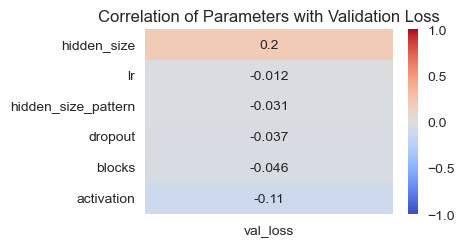

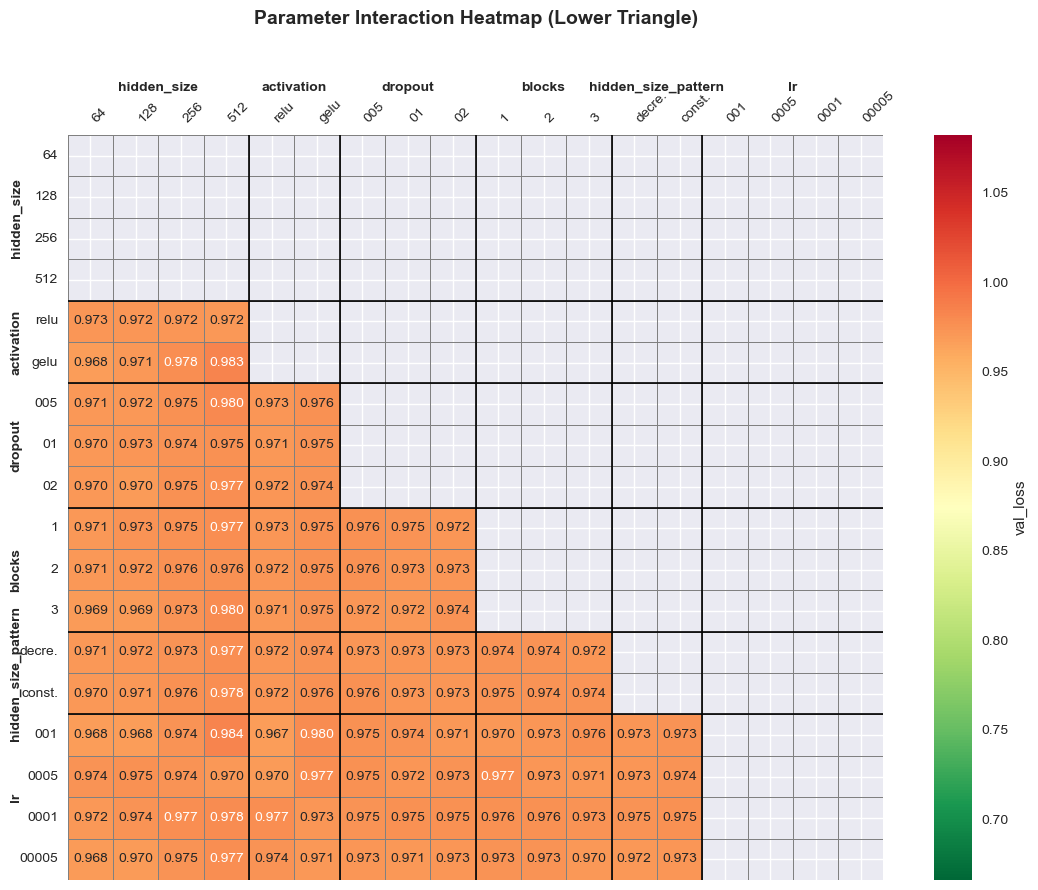



📈 Tuning results for TFIDF + CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
3048,relu,2,0.20,128,decreasing,0.010,0.334313,0.684996,33.188759,10.743826,45.118511,13.192778,0.538850,0.227518,24.412628,9.586085
3060,relu,2,0.20,256,constant,0.010,0.347538,0.686444,32.922142,10.892530,44.846832,13.247002,0.544387,0.221155,22.800903,9.493479
2994,relu,2,0.05,256,decreasing,0.001,0.242526,0.691881,34.997036,10.658179,45.935638,13.175475,0.521995,0.229543,27.410828,9.188665
3165,relu,3,0.20,512,constant,0.005,0.300667,0.693412,33.083088,10.865457,43.746311,13.484983,0.566474,0.192919,25.044647,9.531021
3056,relu,2,0.20,256,decreasing,0.010,0.364691,0.695484,35.053715,10.680581,47.966347,12.947969,0.478798,0.255920,25.534576,9.748121



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
2960,relu,1,0.2,256,decreasing,0.010,0.253883,0.713081,32.426395,11.292360,44.152161,13.697038,0.558393,0.167337,24.148407,10.516788
2940,relu,1,0.1,512,constant,0.010,0.056332,0.703586,32.517628,10.816490,44.383873,13.547293,0.553745,0.185444,24.696625,8.819836
3109,relu,3,0.1,64,constant,0.005,0.347358,0.730490,32.541733,11.100758,44.888638,13.843560,0.543537,0.149427,25.032349,9.648264
3153,relu,3,0.2,256,decreasing,0.005,0.227487,0.696840,32.720493,10.541672,44.618088,13.417776,0.549023,0.200944,24.340607,8.425241
3060,relu,2,0.2,256,constant,0.010,0.347538,0.686444,32.922142,10.892530,44.846832,13.247002,0.544387,0.221155,22.800903,9.493479



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
3040,relu,2,0.2,64,decreasing,0.010,0.260031,0.715153,36.071735,10.318444,49.457214,13.001412,0.445895,0.249765,26.429596,8.926447
3068,relu,2,0.2,512,constant,0.010,0.338149,0.701063,35.618252,10.446930,47.689632,13.066121,0.484795,0.242279,27.084991,9.347519
2933,relu,1,0.1,256,constant,0.005,0.241839,0.717975,36.105869,10.511385,48.093460,13.242313,0.476032,0.221706,28.588470,8.868490
3029,relu,2,0.1,256,constant,0.005,0.212072,0.705250,34.200348,10.536549,46.376804,13.305558,0.512770,0.214254,26.911621,8.252403
3153,relu,3,0.2,256,decreasing,0.005,0.227487,0.696840,32.720493,10.541672,44.618088,13.417776,0.549023,0.200944,24.340607,8.425241


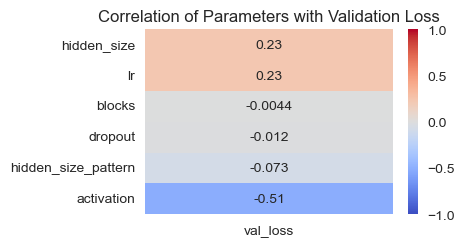

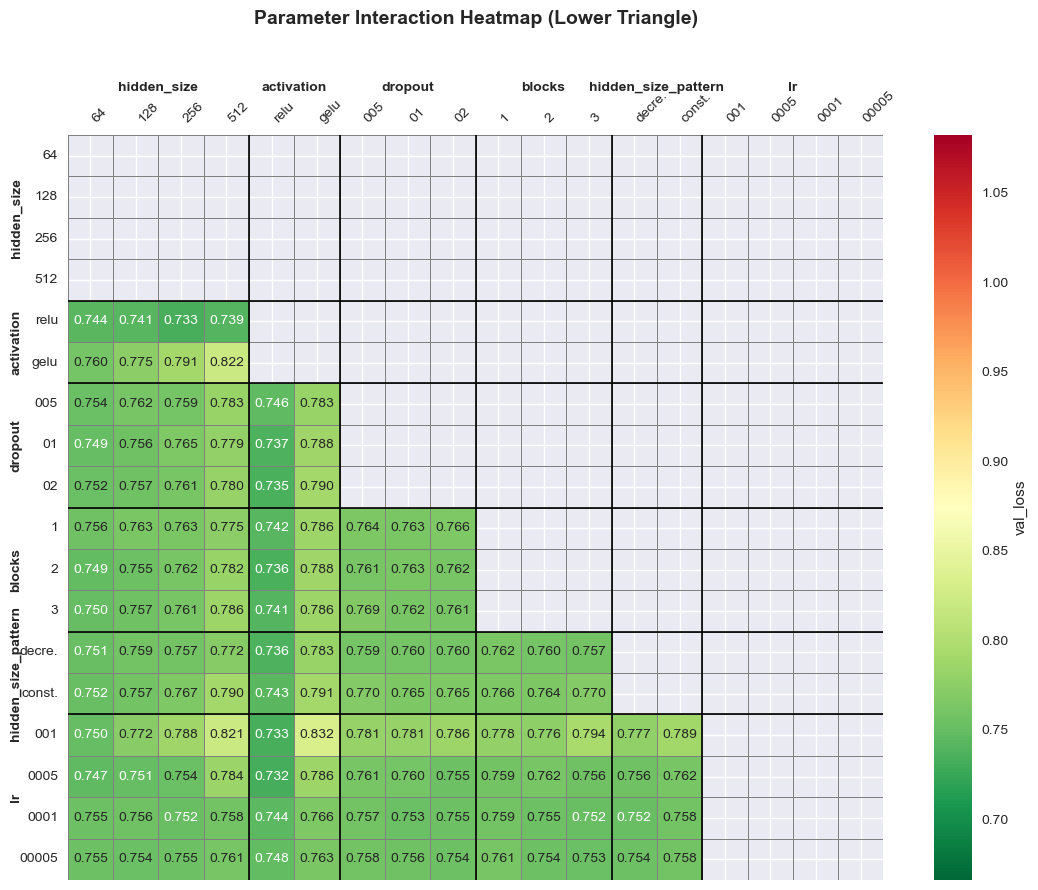



📈 Tuning results for TFIDF + RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
3516,relu,1,0.10,512,constant,0.010,0.025344,0.666215,31.435915,10.327536,42.717396,13.236004,0.586627,0.222447,23.283813,8.545528
3632,relu,2,0.20,256,decreasing,0.010,0.189427,0.676208,33.360168,10.255352,45.258148,13.049498,0.535991,0.244206,25.750916,8.433260
3640,relu,2,0.20,512,decreasing,0.010,0.232435,0.683468,32.403633,10.496857,45.039074,13.180222,0.540473,0.228987,20.687927,9.057778
3517,relu,1,0.10,512,constant,0.005,0.076119,0.690952,33.419296,10.475766,45.179451,13.262949,0.537604,0.219278,23.875000,8.600952
3672,relu,3,0.05,512,decreasing,0.010,0.363050,0.692677,33.905830,10.918922,45.040924,13.305168,0.540435,0.214300,24.692627,9.685986



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
3516,relu,1,0.1,512,constant,0.01,0.025344,0.666215,31.435915,10.327536,42.717396,13.236004,0.586627,0.222447,23.283813,8.545528
3608,relu,2,0.1,512,decreasing,0.01,0.053081,0.701191,31.834888,10.906832,43.085464,13.674024,0.579473,0.170132,23.490295,8.742967
3640,relu,2,0.2,512,decreasing,0.01,0.232435,0.683468,32.403633,10.496857,45.039074,13.180222,0.540473,0.228987,20.687927,9.057778
3536,relu,1,0.2,256,decreasing,0.01,0.099147,0.696071,32.449318,10.558726,45.475021,13.295988,0.531534,0.215384,23.830048,9.102652
3544,relu,1,0.2,512,decreasing,0.01,0.056020,0.707833,32.674553,10.626588,43.921379,13.658978,0.562997,0.171958,23.404266,8.303131



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
3632,relu,2,0.20,256,decreasing,0.010,0.189427,0.676208,33.360168,10.255352,45.258148,13.049498,0.535991,0.244206,25.750916,8.433260
3516,relu,1,0.10,512,constant,0.010,0.025344,0.666215,31.435915,10.327536,42.717396,13.236004,0.586627,0.222447,23.283813,8.545528
3581,relu,2,0.05,512,constant,0.005,0.020398,0.720634,33.618340,10.401696,46.500904,13.499595,0.510159,0.191170,24.297211,8.218807
3612,relu,2,0.10,512,constant,0.010,0.146017,0.719035,34.014671,10.401973,45.897034,13.560183,0.522799,0.183893,25.406555,7.831416
3517,relu,1,0.10,512,constant,0.005,0.076119,0.690952,33.419296,10.475766,45.179451,13.262949,0.537604,0.219278,23.875000,8.600952


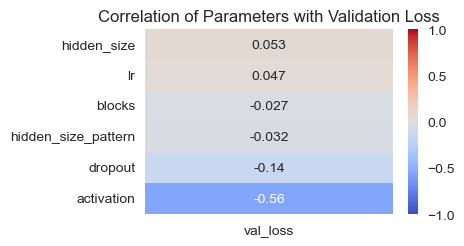

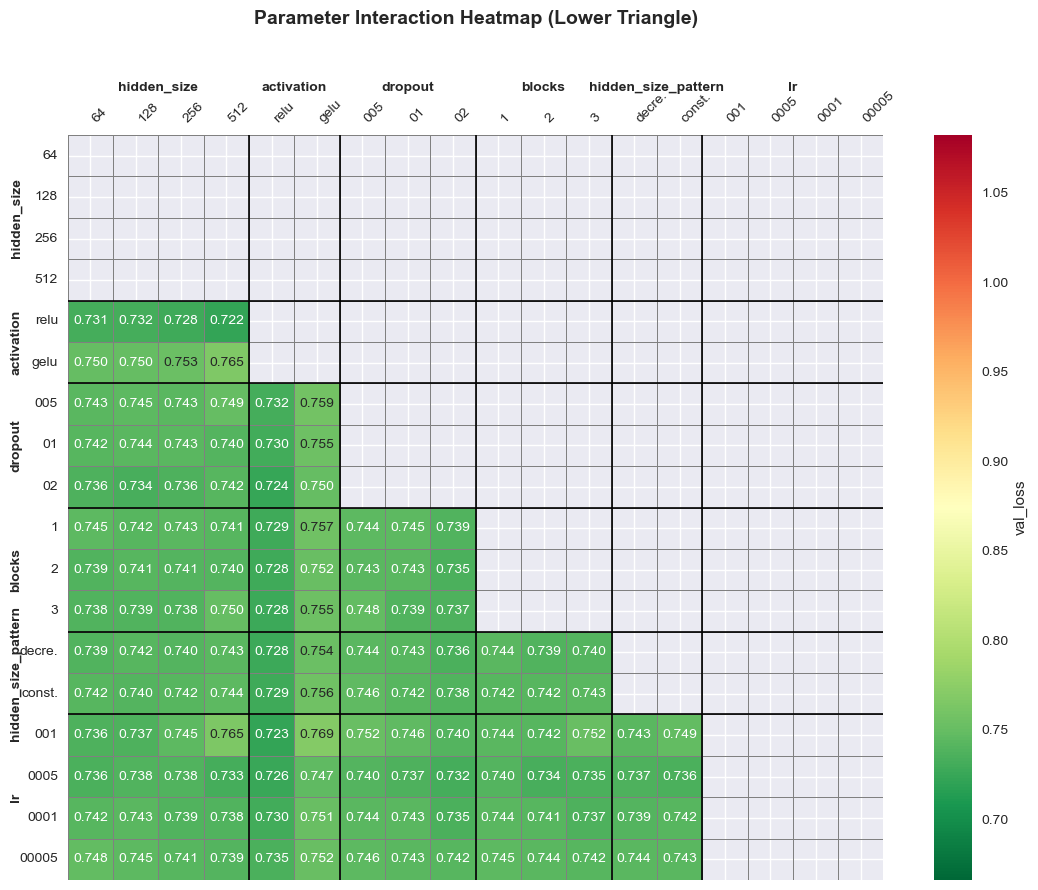



📈 Tuning results for TFIDF + VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
4189,relu,2,0.10,512,constant,0.005,0.246393,0.694086,32.176670,10.970652,43.559872,13.512754,0.570161,0.189592,22.415558,9.532871
4296,relu,3,0.20,128,decreasing,0.010,0.268063,0.694667,33.193016,10.737274,44.925312,13.353086,0.542791,0.208630,24.023163,8.859098
4044,relu,1,0.05,128,constant,0.010,0.040325,0.695479,34.106339,10.386637,45.518085,13.285851,0.530646,0.216580,25.117889,9.207416
4060,relu,1,0.05,512,constant,0.010,0.252378,0.703545,34.377354,11.196499,44.698475,13.494339,0.547397,0.191799,28.129883,9.830864
4092,relu,1,0.10,512,constant,0.010,0.219358,0.708430,35.266560,10.434981,47.414520,13.200410,0.490722,0.226624,26.557007,8.589591



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
4189,relu,2,0.1,512,constant,0.005,0.246393,0.694086,32.176670,10.970652,43.559872,13.512754,0.570161,0.189592,22.415558,9.532871
4317,relu,3,0.2,512,constant,0.005,0.110557,0.711857,32.258625,10.811855,44.561409,13.629566,0.550168,0.175520,21.959900,8.996309
4084,relu,1,0.1,256,constant,0.010,0.041148,0.709472,32.386333,11.016635,42.371056,13.870324,0.593303,0.146135,24.879974,9.380535
4264,relu,3,0.1,128,decreasing,0.010,0.308904,0.714786,32.776054,11.089067,43.594177,13.793303,0.569484,0.155591,26.437866,8.956465
4089,relu,1,0.1,512,decreasing,0.005,0.100189,0.721869,32.881554,10.859175,44.447258,13.776618,0.552470,0.157633,24.786621,9.579608



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
4044,relu,1,0.05,128,constant,0.010,0.040325,0.695479,34.106339,10.386637,45.518085,13.285851,0.530646,0.216580,25.117889,9.207416
4092,relu,1,0.10,512,constant,0.010,0.219358,0.708430,35.266560,10.434981,47.414520,13.200410,0.490722,0.226624,26.557007,8.589591
4312,relu,3,0.20,512,decreasing,0.010,0.301698,0.722688,36.376541,10.499131,47.652557,13.366939,0.485595,0.206988,29.010345,8.567928
4085,relu,1,0.10,256,constant,0.005,0.260683,0.717749,35.863613,10.544032,47.683125,13.291373,0.484935,0.215928,26.745209,8.540833
4088,relu,1,0.10,512,decreasing,0.010,0.192089,0.723686,35.446617,10.544570,48.193737,13.302011,0.473845,0.214673,26.430573,10.083647


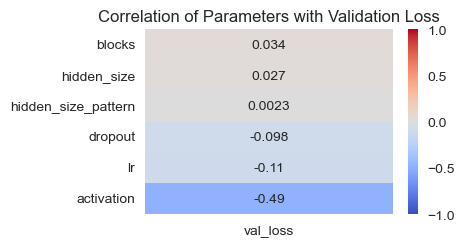

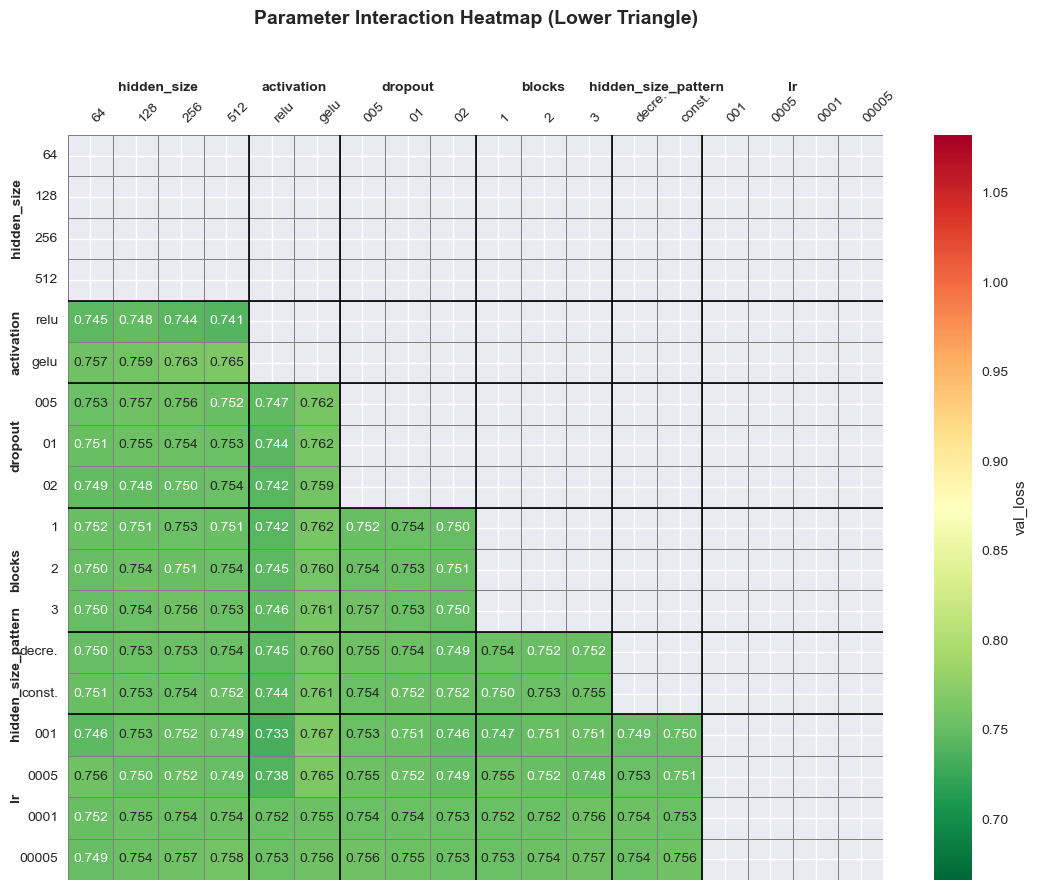



📈 Tuning results for BERT + CANNYHOG features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
5034,gelu,2,0.1,128,decreasing,0.0010,0.435122,0.825365,39.992924,11.688474,53.067463,13.977118,0.362046,0.132936,28.916107,11.280685
4785,relu,2,0.2,256,decreasing,0.0050,0.675249,0.826788,41.240299,12.359145,52.701584,14.047100,0.370813,0.124231,33.951569,11.737465
4934,gelu,1,0.1,64,constant,0.0010,0.469261,0.827882,40.292770,11.892616,52.144337,14.142124,0.384048,0.112343,32.177032,11.109906
4798,relu,2,0.2,512,constant,0.0010,0.570579,0.832908,41.384304,12.180856,52.371635,14.176795,0.378667,0.107985,35.931305,12.083775
4835,relu,3,0.1,64,decreasing,0.0005,0.556259,0.835913,40.142372,12.215222,52.367226,14.215199,0.378771,0.103146,31.231659,11.503469



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
5069,gelu,2,0.20,128,constant,0.005,0.600863,0.848592,39.645256,12.285640,52.993328,14.291473,0.363828,0.093495,30.375732,11.166004
5073,gelu,2,0.20,256,decreasing,0.005,0.668464,0.840639,39.722595,12.609590,50.645462,14.517303,0.418950,0.064620,32.888794,11.984631
5028,gelu,2,0.10,64,constant,0.010,0.623277,0.854711,39.766922,12.584567,51.166084,14.623424,0.406942,0.050895,32.133331,11.631765
5097,gelu,3,0.05,128,decreasing,0.005,0.544675,0.849265,39.814381,12.205773,53.662315,14.206310,0.347664,0.104267,29.317871,11.634131
5128,gelu,3,0.10,128,decreasing,0.010,0.564668,0.841478,39.869541,12.240673,52.553223,14.260471,0.374350,0.097424,31.367157,11.337943



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
5034,gelu,2,0.1,128,decreasing,0.0010,0.435122,0.825365,39.992924,11.688474,53.067463,13.977118,0.362046,0.132936,28.916107,11.280685
4934,gelu,1,0.1,64,constant,0.0010,0.469261,0.827882,40.292770,11.892616,52.144337,14.142124,0.384048,0.112343,32.177032,11.109906
4649,relu,1,0.1,128,decreasing,0.0050,0.503755,0.840113,41.394451,11.900442,54.086746,14.021923,0.337304,0.127368,33.548767,11.338951
5183,gelu,3,0.2,512,constant,0.0005,0.572216,0.867710,42.088772,11.905359,55.046886,14.235336,0.313567,0.100603,32.904144,10.996297
5086,gelu,2,0.2,512,constant,0.0010,0.540879,0.888669,43.616470,11.933619,57.218616,14.174429,0.258336,0.108283,34.770905,11.230455


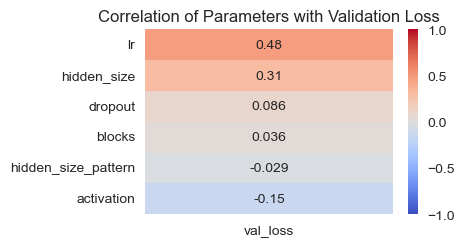

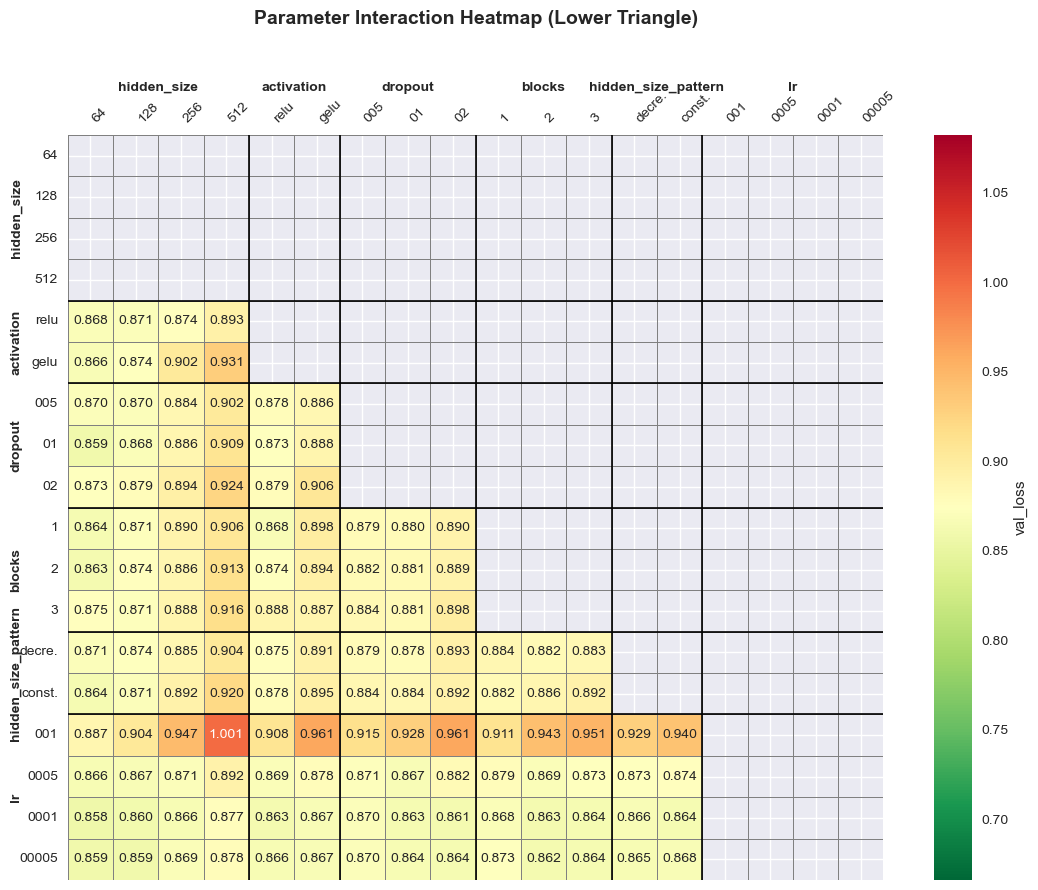



📈 Tuning results for BERT + RESNET features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
5384,relu,3,0.05,128,decreasing,0.010,0.502342,0.820415,41.849033,11.567339,53.914349,13.779701,0.341522,0.157256,32.399292,10.508677
5536,gelu,1,0.20,64,decreasing,0.010,0.612843,0.824497,39.957211,12.438063,51.314861,14.215594,0.403489,0.103096,33.021484,11.989221
5436,relu,3,0.10,512,constant,0.010,0.565557,0.826677,40.201454,11.876007,53.054852,13.989470,0.362350,0.131402,29.664337,11.106668
5698,gelu,3,0.10,64,decreasing,0.001,0.602511,0.828225,40.125706,12.418746,51.147156,14.286201,0.407381,0.094164,34.410736,11.907010
5508,gelu,1,0.10,64,constant,0.010,0.531318,0.830505,39.687241,12.256598,50.699764,14.379145,0.417703,0.082339,33.378021,11.411604



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
5285,relu,2,0.05,64,constant,0.005,0.467002,0.864668,39.139008,12.469913,51.317886,14.731328,0.403418,0.036837,30.556091,11.946255
5404,relu,3,0.05,512,constant,0.010,0.500148,0.847212,39.157948,12.286500,51.752621,14.446580,0.393268,0.073712,29.979126,11.954998
5621,gelu,2,0.10,256,constant,0.005,0.570503,0.855267,39.257694,12.467273,51.222713,14.622826,0.405629,0.050973,31.250000,11.713860
5370,relu,2,0.20,512,decreasing,0.001,0.484609,0.859580,39.330967,12.417240,51.796371,14.598631,0.392241,0.054111,31.377106,11.862660
5377,relu,3,0.05,64,decreasing,0.005,0.507832,0.887231,39.366444,12.771567,51.776382,14.946294,0.392710,0.008522,29.680359,12.007394



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
5384,relu,3,0.05,128,decreasing,0.01,0.502342,0.820415,41.849033,11.567339,53.914349,13.779701,0.341522,0.157256,32.399292,10.508677
5436,relu,3,0.10,512,constant,0.01,0.565557,0.826677,40.201454,11.876007,53.054852,13.989470,0.362350,0.131402,29.664337,11.106668
5632,gelu,2,0.20,64,decreasing,0.01,0.609802,0.831416,41.480091,11.930968,53.670254,13.961926,0.347471,0.134819,32.211334,10.643253
5380,relu,3,0.05,64,constant,0.01,0.591295,0.914663,44.777138,12.041624,57.534801,14.454104,0.250117,0.072747,37.278717,11.417935
5716,gelu,3,0.10,256,constant,0.01,0.547127,0.845495,41.012226,12.104537,53.405865,14.187026,0.353884,0.106697,30.799377,11.437710


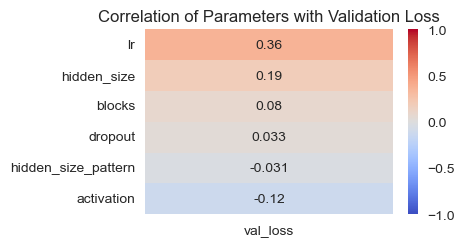

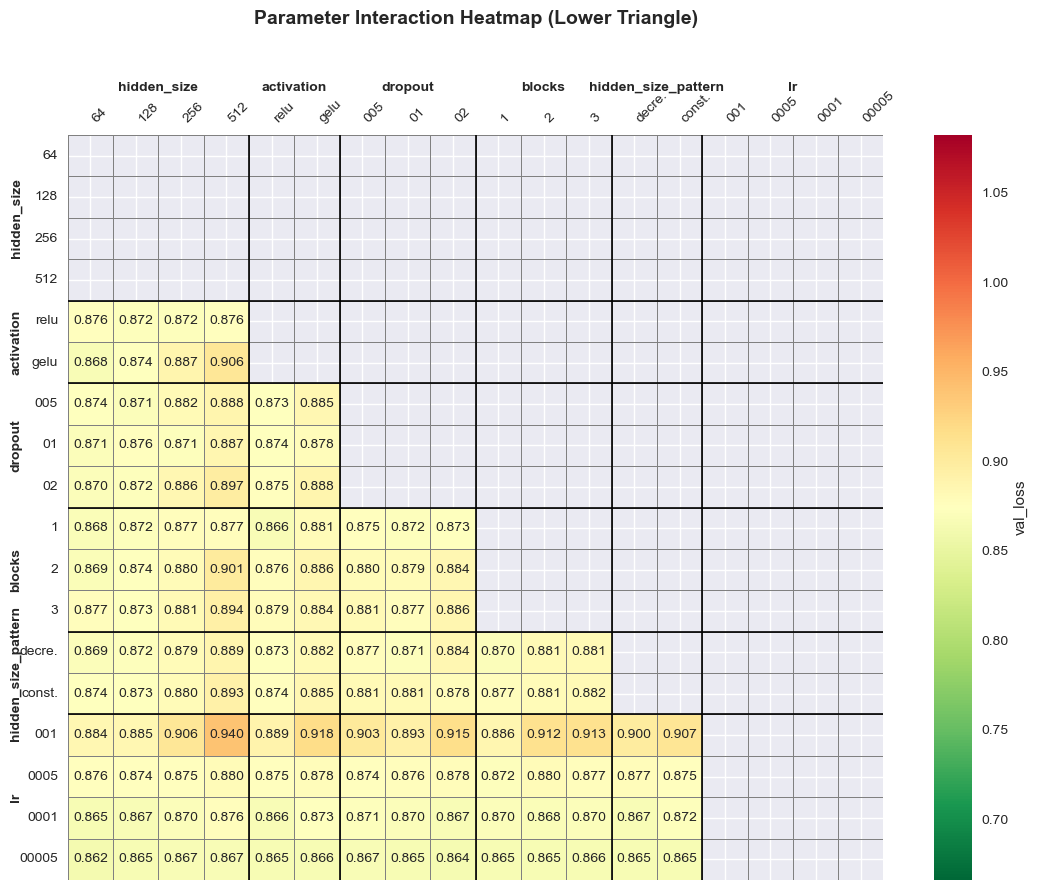



📈 Tuning results for BERT + VIT features model:

Top 5 by val_loss:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
5984,relu,3,0.10,64,decreasing,0.0100,0.608465,0.828677,39.460720,12.191565,51.133957,14.292937,0.407687,0.093309,33.483765,11.848417
6244,gelu,3,0.05,64,constant,0.0100,0.521673,0.829025,38.583981,12.222920,51.048447,14.309723,0.409666,0.091179,29.682587,11.334533
5849,relu,1,0.20,512,decreasing,0.0050,0.405616,0.832069,37.299103,12.199654,49.605862,14.540642,0.442560,0.061610,27.468292,10.781502
6311,gelu,3,0.20,64,constant,0.0005,0.585211,0.835841,40.308685,12.506614,51.923889,14.273122,0.389245,0.095822,32.632782,11.921519
6305,gelu,3,0.20,64,decreasing,0.0050,0.570056,0.841792,38.700855,12.522617,50.244427,14.580514,0.428116,0.056457,29.613525,11.442785



Top 5 by mae_0:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
6265,gelu,3,0.05,512,decreasing,0.005,0.404672,0.880277,37.052322,12.449943,50.601772,15.013247,0.419952,-0.000381,23.851440,11.338861
5973,relu,3,0.05,256,constant,0.005,0.405829,0.845215,37.057858,12.310302,49.151814,14.770001,0.452718,0.031773,28.374359,10.752384
5849,relu,1,0.20,512,decreasing,0.005,0.405616,0.832069,37.299103,12.199654,49.605862,14.540642,0.442560,0.061610,27.468292,10.781502
5912,relu,2,0.10,512,decreasing,0.010,0.460766,0.861774,37.790657,12.673856,50.003368,14.866715,0.433590,0.019052,27.684113,11.639520
6273,gelu,3,0.10,64,decreasing,0.005,0.473124,0.863463,37.803078,12.686749,49.059921,15.009462,0.454762,0.000124,28.609192,11.888711



Top 5 by mae_1:


,activation,blocks,dropout,hidden_size,hidden_size_pattern,lr,train_loss,val_loss,mae_0,mae_1,rmse_0,rmse_1,r2_0,r2_1,medae_0,medae_1
6325,gelu,3,0.20,256,constant,0.005,0.593170,0.872533,41.571442,12.096915,53.238613,14.554005,0.357925,0.059885,34.271423,10.683886
6020,relu,3,0.20,64,constant,0.010,0.616379,0.869747,42.097080,12.118103,54.576473,14.324156,0.325249,0.089344,34.303833,12.015056
5984,relu,3,0.10,64,decreasing,0.010,0.608465,0.828677,39.460720,12.191565,51.133957,14.292937,0.407687,0.093309,33.483765,11.848417
5849,relu,1,0.20,512,decreasing,0.005,0.405616,0.832069,37.299103,12.199654,49.605862,14.540642,0.442560,0.061610,27.468292,10.781502
5964,relu,3,0.05,128,constant,0.010,0.532495,0.871417,40.874069,12.221391,54.888138,14.298339,0.317521,0.092624,30.980255,11.221003


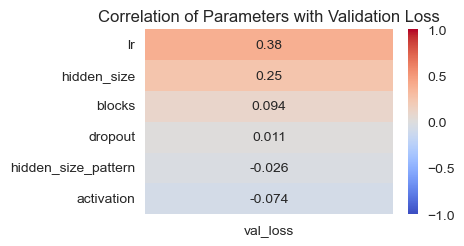

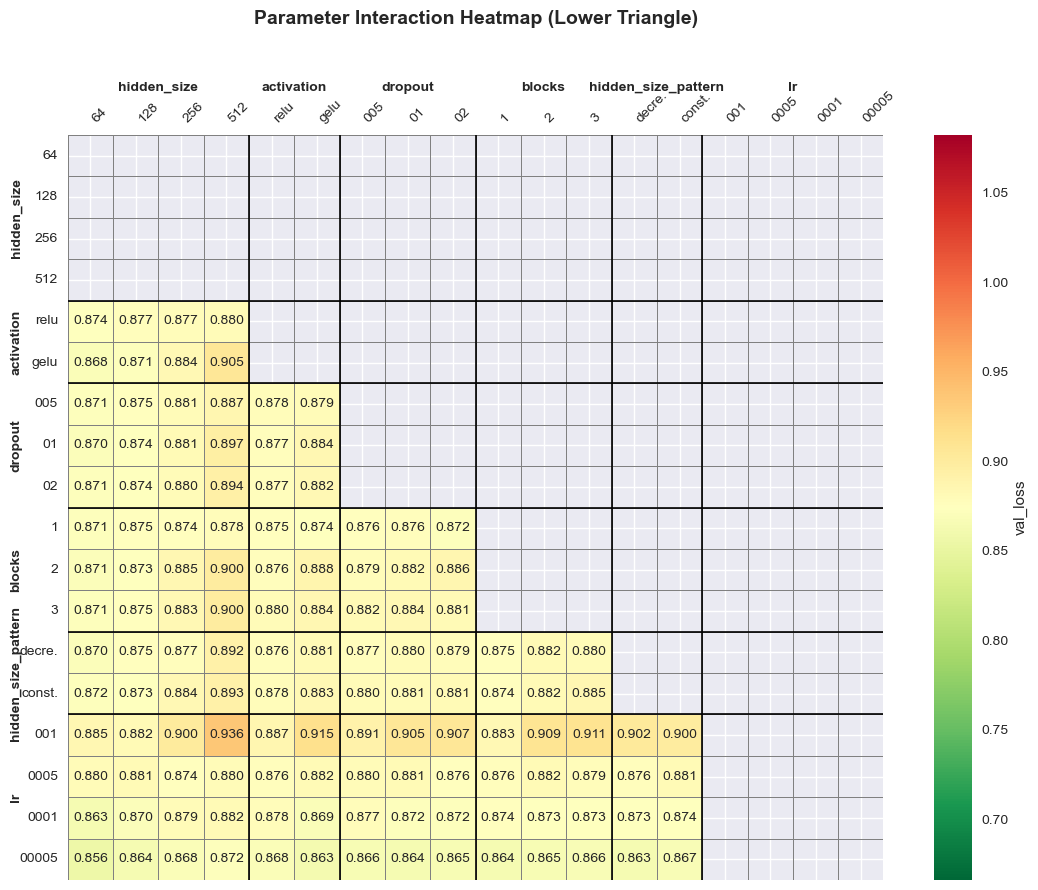

In [17]:
all_val_losses = pd.concat([tuning_history["val_loss"] for tuning_history in tuning_histories.values()])
val_loss_range = (all_val_losses.min(), all_val_losses.max())
print(val_loss_range)

for ft, tuning_history in tuning_histories.items():
    print(f"\n\n📈 Tuning results for {ft.upper()} features model:")
    print_tuning_top_results(tuning_history, topN=5, top_by=["val_loss", "mae"])

    plot_param_loss_corr(tuning_history, param_grid)
    plot_tuning_heatmap(tuning_history, param_grid, loss_range=val_loss_range)